In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'bilalyousaf0014'
os.environ['KAGGLE_KEY'] = '11031bc21c5e3ec23585dbe17dc4267d'

In [3]:
!kaggle datasets download -d bilalyousaf0014/ml-engineer-assessment-dataset

Dataset URL: https://www.kaggle.com/datasets/bilalyousaf0014/ml-engineer-assessment-dataset
License(s): unknown




  0%|          | 0.00/78.6M [00:00<?, ?B/s]
  1%|▏         | 1.00M/78.6M [00:01<01:22, 988kB/s]
  3%|▎         | 2.00M/78.6M [00:01<00:42, 1.88MB/s]
  4%|▍         | 3.00M/78.6M [00:01<00:42, 1.88MB/s]
  5%|▌         | 4.00M/78.6M [00:02<00:30, 2.54MB/s]
  6%|▋         | 5.00M/78.6M [00:02<00:23, 3.24MB/s]
  8%|▊         | 6.00M/78.6M [00:02<00:34, 2.24MB/s]
  9%|▉         | 7.00M/78.6M [00:03<00:28, 2.67MB/s]
 10%|█         | 8.00M/78.6M [00:03<00:36, 2.03MB/s]
 11%|█▏        | 9.00M/78.6M [00:04<00:30, 2.38MB/s]
 13%|█▎        | 10.0M/78.6M [00:04<00:32, 2.19MB/s]
 14%|█▍        | 11.0M/78.6M [00:04<00:25, 2.81MB/s]
 15%|█▌        | 12.0M/78.6M [00:05<00:20, 3.39MB/s]
 17%|█▋        | 13.0M/78.6M [00:06<00:39, 1.76MB/s]
 18%|█▊        | 14.0M/78.6M [00:06<00:30, 2.26MB/s]
 19%|█▉        | 15.0M/78.6M [00:06<00:25, 2.57MB/s]
 20%|██        | 16.0M/78.6M [00:06<00:21, 3.03MB/s]
 22%|██▏       | 17.0M/78.6M [00:07<00:28, 2.26MB/s]
 23%|██▎       | 18.0M/78.6M [00:08<00:25, 2.50MB/s]
 2

In [380]:
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [381]:
specie_label_to_idx = {}
i = 0

for path in os.listdir("./Dataset/labels/"):
  name = "_".join(path.split(".")[0].split("_")[:-1])
  if name not in specie_label_to_idx:
    specie_label_to_idx[name] = i
    i += 1

specie_label_to_idx['NA'] = len(specie_label_to_idx)
specie_idx_to_label = {val:key for (key, val) in specie_label_to_idx.items()}
specie_idx_to_label,specie_label_to_idx

({0: 'Abyssinian',
  1: 'american_bulldog',
  2: 'american_pit_bull_terrier',
  3: 'basset_hound',
  4: 'beagle',
  5: 'Birman',
  6: 'chihuahua',
  7: 'Persian',
  8: 'pomeranian',
  9: 'NA'},
 {'Abyssinian': 0,
  'american_bulldog': 1,
  'american_pit_bull_terrier': 2,
  'basset_hound': 3,
  'beagle': 4,
  'Birman': 5,
  'chihuahua': 6,
  'Persian': 7,
  'pomeranian': 8,
  'NA': 9})

In [382]:
cat_or_dog_label_to_idx = {'cat': 0, 'dog': 1, 'NA': 2}
cat_or_dog_idx_to_label = {0: 'cat', 1: 'dog', 2: 'NA'}

In [383]:
from bs4 import BeautifulSoup

def read_xml_file(path):
    with open(path, 'r') as f:
        data = f.read()
    bs_data = BeautifulSoup(data, 'xml')
    return {
        "cat_or_dog": bs_data.find("name").text,
        "xmin": int(bs_data.find("xmin").text),
        "ymin": int(bs_data.find("ymin").text),
        "xmax": int(bs_data.find("xmax").text),
        "ymax": int(bs_data.find("ymax").text),
        "specie": "_".join(path.split(os.sep)[-1].split("_")[:-1])
    }

In [384]:
class CustomDataset(Dataset):
    def __init__(self,datasetPath,images_list):
        super().__init__()
        self.preprocess=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
        imageFolderPath=os.path.join(datasetPath,'images')
        labelFolderPath=os.path.join(datasetPath,'labels')
        self.images=[]
        self.labels=[]
        for path in os.listdir(imageFolderPath):
            name = path.split(os.sep)[-1].split(".")[0]
            if name in images_list:
                try:
                    image_path=os.path.join(imageFolderPath,path)
                    xml_path=os.path.join(labelFolderPath,name+".xml")
                    xml_data=read_xml_file(xml_path)
                    self.labels.append(xml_data)
                    self.images.append(Image.open(image_path))
                except:
                    xml_data = {'cat_or_dog': 'NA',
                      'xmin': 0,
                      'ymin': 0,
                      'xmax': 0,
                      'ymax': 0,
                      'specie': 'NA'}
                self.labels.append(xml_data)
                self.images.append(Image.open(os.path.join(imageFolderPath, path)))
        
    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)
    
    def __getitem__(self, index):
        image=self.preprocess(self.images[index])
        labels=self.labels[index]

        try: 
            labels['specie'] = specie_label_to_idx[labels['specie']]
            labels['cat_or_dog'] = cat_or_dog_label_to_idx[labels['cat_or_dog']]
            labels['object'] = 1 if labels['cat_or_dog'] != 2 else 0
            labels['bbox'] = [labels['xmin'],labels['ymin'],labels['xmax'],labels['ymax']]
        except:
            pass
        return image,labels

In [385]:
train_list=np.load('Dataset/train_list.npy',allow_pickle=True).tolist()
val_list=np.load('Dataset/val_list.npy',allow_pickle=True).tolist()

In [386]:
trainingDataset=CustomDataset('Dataset',images_list=train_list)
trainingDataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

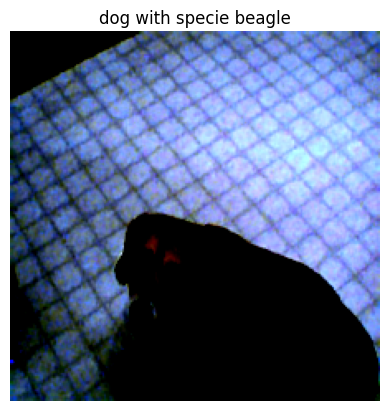

In [387]:
import matplotlib.pyplot as plt

randomIndex=np.random.randint(0,len(trainingDataset))
image,label=trainingDataset[randomIndex]
permute=image.permute(1,2,0)
plt.imshow(permute)
plt.title(f"{cat_or_dog_idx_to_label[label['cat_or_dog']]} with specie {specie_idx_to_label[label['specie']]}")
plt.axis('off')

In [388]:
label

{'cat_or_dog': 1,
 'xmin': 100,
 'ymin': 143,
 'xmax': 212,
 'ymax': 257,
 'specie': 4,
 'object': 1,
 'bbox': [100, 143, 212, 257]}

In [389]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        pretrained_model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(pretrained_model.children())[:-1])

        self.is_object=nn.Linear(in_features=512,out_features=1)
        self.cat_or_dog=nn.Linear(in_features=512,out_features=3)
        self.species=nn.Linear(in_features=512,out_features=10)
        self.bounding_box=nn.Linear(in_features=512,out_features=4)

    def forward(self,input):
        inBackbone=self.backbone(input)
        outBackbone=torch.flatten(inBackbone,1)
        is_object=self.is_object(outBackbone)
        cat_or_dog=self.cat_or_dog(outBackbone)
        species=self.species(outBackbone)
        boundingBox=self.bounding_box(outBackbone)

        return {
            "bbox":boundingBox,
            "isObject":is_object,
            "cat_or_dog":cat_or_dog,
            "species":species
        }

In [390]:
model=Model()
model.eval()

Model(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [391]:
sampleOutput=model(image.unsqueeze(dim=0))
sampleOutput

{'bbox': tensor([[-0.1489,  0.9285, -0.4918,  0.8430]], grad_fn=<AddmmBackward0>),
 'isObject': tensor([[0.4773]], grad_fn=<AddmmBackward0>),
 'cat_or_dog': tensor([[ 0.2710, -1.1320,  0.1924]], grad_fn=<AddmmBackward0>),
 'species': tensor([[-0.3849, -0.1878, -0.0365, -0.4369,  0.3385,  0.4761, -0.7723,  0.0745,
          -0.9709, -0.7064]], grad_fn=<AddmmBackward0>)}

In [392]:
dataloader = DataLoader(trainingDataset, batch_size=32, shuffle=True, num_workers=0)  # Use smaller batch size
dataloader

In [393]:
# Define the loss functions
criterion_isObject = nn.BCEWithLogitsLoss()  # For binary classification (isObject)
criterion_cat_or_dog = nn.CrossEntropyLoss()  # For multi-class classification (cat_or_dog)
criterion_species = nn.CrossEntropyLoss()      # For multi-class classification (species)
criterion_bbox = nn.SmoothL1Loss()             # For bounding box regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [394]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

Model(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [395]:
num_epochs=25
for epoch in range(num_epochs):
    print("Training Epoch : "+str(epoch))
    for features, labels in dataloader:
        optimizer.zero_grad()
        
        outputs = model(features)
        outputObject=outputs['isObject'].squeeze().to(torch.float32)
        outputCatOrDog=outputs['cat_or_dog'].squeeze().to(torch.float32)
        outputSpecies=outputs['species'].squeeze().to(torch.float32)
        outputBBOX=outputs['bbox'].squeeze().to(torch.float32)

        labelsObject=labels['object'].to(torch.float32)
        labelsCatOrDog=torch.nn.functional.one_hot(labels['cat_or_dog'].to(torch.int64).long(),len(cat_or_dog_idx_to_label)).float()
        labelsSpecies=torch.nn.functional.one_hot(labels['specie'].to(torch.int64).long(), len(specie_idx_to_label)).float()
        labelsBBOX=torch.tensor([[labels['xmin'][i], labels['ymin'][i], labels['xmax'][i], labels['ymax'][i]] for i in range(len(labels['xmin']))], dtype=torch.float32)
           

        loss_isObject = criterion_isObject(outputObject,labelsObject)
        loss_cat_or_dog = criterion_cat_or_dog(outputCatOrDog, labelsCatOrDog)
        loss_species = criterion_species(outputSpecies, labelsSpecies)
        loss_bbox = criterion_bbox(outputBBOX, labelsBBOX)
        total_loss = loss_bbox*0.0001 + loss_isObject*10 + loss_cat_or_dog*10 + loss_species*100
        print(f"Loss Object {loss_isObject} | Loss Cat or Dog {loss_cat_or_dog} | Loss Species {loss_species} | Loss BBOX {loss_bbox}")
        print(f"Total Loss {total_loss}")
        # Total loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

Training Epoch : 0
Loss Object 0.6457518935203552 | Loss Cat or Dog 0.950768768787384 | Loss Species 2.256016254425049 | Loss BBOX 144.0635528564453
Total Loss 241.58123779296875
Loss Object 0.1654951274394989 | Loss Cat or Dog 0.9746688008308411 | Loss Species 6.908993721008301 | Loss BBOX 173.78121948242188
Total Loss 702.318359375
Loss Object 0.22847703099250793 | Loss Cat or Dog 2.4555304050445557 | Loss Species 3.481945753097534 | Loss BBOX 170.5261993408203
Total Loss 375.05169677734375
Loss Object 0.5153642892837524 | Loss Cat or Dog 1.3282357454299927 | Loss Species 2.480574369430542 | Loss BBOX 173.04998779296875
Total Loss 266.5107421875
Loss Object 0.8796882629394531 | Loss Cat or Dog 1.365776538848877 | Loss Species 2.5627591609954834 | Loss BBOX 148.8341522216797
Total Loss 278.7454528808594
Loss Object 0.7743664979934692 | Loss Cat or Dog 1.2148585319519043 | Loss Species 2.358625650405884 | Loss BBOX 140.42568969726562
Total Loss 255.76885986328125
Loss Object 0.66338574

In [396]:
validationData=CustomDataset('Dataset',val_list)
validationData

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

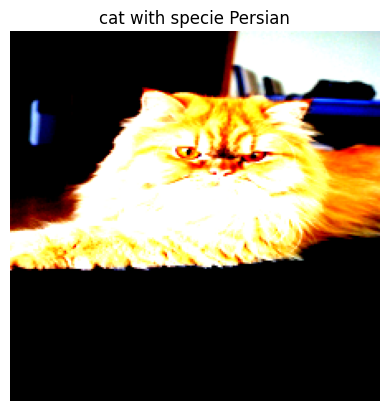

In [423]:
import matplotlib.pyplot as plt

randomIndex=np.random.randint(0,len(validationData))
image,label=validationData[randomIndex]
permute=image.permute(1,2,0)
plt.imshow(permute)
plt.title(f"{cat_or_dog_idx_to_label[label['cat_or_dog']]} with specie {specie_idx_to_label[label['specie']]}")
plt.axis('off')

In [424]:
predictedImage=model(image.unsqueeze(dim=0))
predictedImage

{'bbox': tensor([[2.8491, 2.5682, 2.7833, 2.3822]], grad_fn=<AddmmBackward0>),
 'isObject': tensor([[1.1686]], grad_fn=<AddmmBackward0>),
 'cat_or_dog': tensor([[ 0.7238,  0.3905, -0.6362]], grad_fn=<AddmmBackward0>),
 'species': tensor([[ 0.6422, -0.0252,  0.0319,  0.6149,  0.0563,  0.1467,  0.4075,  0.3336,
          -0.2858, -1.3203]], grad_fn=<AddmmBackward0>)}

In [425]:
isObject = torch.round(predictedImage['isObject']).to(torch.int64)
isObject=torch.sigmoid(isObject)
isObject

tensor([[0.7311]])

In [426]:
cat_or_dog=torch.argmax(predictedImage['cat_or_dog'])
cat_or_dog_idx_to_label[int(cat_or_dog)]

'cat'

In [427]:
species=torch.argmax(predictedImage['species'])
specie_idx_to_label[int(species)]

'Abyssinian'